## Importando bibliotecas

In [1]:
from IPython.display import clear_output

In [2]:
# caso precise utilizar GPU
# https://www.youtube.com/watch?v=ryFFCyhTgyA
# !pip install tensorflow-gpu==2.10.0

# import subprocess
# command = "nvidia-smi --query-gpu=name,memory.total --format=csv,noheader,nounits"
# output = subprocess.check_output(command, shell=True, encoding='utf-8')
# for idx, line in enumerate(output.splitlines()):
#     name, memory = line.strip().split(',')
#     print(f"GPU {idx} - Nome {name}, Memória total: {memory} MB")

clear_output()

In [3]:
# comentar esta linha caso use GPU
!pip install tensorflow

!pip install pandas yfinance matplotlib scikit-learn joblib pytz python-dateutil pmdarima keras-tuner "numpy<2"

clear_output()

In [4]:
#from reportlab.rl_settings import verbose
import os
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
import tensorflow as tf

import joblib as jl

from pmdarima import auto_arima
import warnings

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

## Métodos auxiliares

In [5]:
warnings.filterwarnings("ignore")

def show_history_details(ticker_history: DataFrame) -> None:
    print(f"Tamanho: {len(ticker_history)}")
    print(f"Data min: {ticker_history.index.min()}")
    print(f"Data max: {ticker_history.index.max()}")


def filter_per_date(history: DataFrame, min_date, max_date) -> DataFrame:
    return history[(history.index >= min_date) & (history.index <= max_date)]


def get_first(dict_tickers_history: dict):
    return next(iter(dict_tickers_history.values()))


def show_dict_tickers_history_details(dict_tickers_history: dict) -> None:
  print(f"Qtd Tickers: {len(dict_tickers_history.keys())}")
  print("Detalhes do primeiro ticker")
  show_history_details(get_first(dict_tickers_history))
  
  
def show_first_ticker_period_details(dict_periods: dict) -> None:
    for periodo, dict_tickers in dict_periods.items():
        first_ticker = get_first(dict_tickers)
        print(f"Período: {periodo}")
        print(f"NumDiffs: {first_ticker['num_diffs']}")
        print(f"ScalerNormalizacao: (Min: {first_ticker['scaler_normalizacao'].data_min_} - Max: {first_ticker['scaler_normalizacao'].data_max_})")
        display(first_ticker["history"].head())
        print("")
  

# TODO: ver se precisa remover
def plot_arima_results(train_history: DataFrame, test_history: DataFrame, dict_pred: dict) -> None:
    # Criando o gráfico
    plt.figure(figsize=(10,6))
    plt.plot(train_history.index, get_prices(train_history), label='Todo treino')
    plt.plot(test_history.index, get_prices(test_history), label='Todo teste')
    
    for periodo, pred in dict_pred.items():
        plt.plot(pred.index, pred.values, label=f'Treino com {periodo}')
    
    # Adicionando rótulos e título
    plt.xlabel('Data')
    plt.ylabel('Valores')
    plt.title('Comparação de predições entre diferentes períodos de treino')
    plt.legend()
    
    # Exibindo o gráfico
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
    plt.tight_layout()  # Ajustar espaçamento
    plt.show()

## Seleção das ações

Para pegar os nomes das ações listadas na B3, fizemos o download de um csv no https://www.dadosdemercado.com.br/acoes.

In [6]:
def get_b3_ticker_symbols() -> list:
    """
    download do csv nesse link: https://www.dadosdemercado.com.br/acoes
    """
    tickers_df = pd.read_csv('acoes-listadas-b3.csv')
    return tickers_df['Ticker'].tolist()

lst_b3_ticker_symbol = get_b3_ticker_symbols()
print(lst_b3_ticker_symbol)

['LREN3', 'B3SA3', 'HAPV3', 'PETR4', 'ENEV3', 'EMBR3', 'ITUB4', 'AZUL4', 'BBDC4', 'ABEV3', 'ITSA4', 'ASAI3', 'COGN3', 'PETZ3', 'PETR3', 'VALE3', 'BBAS3', 'CPLE6', 'RDOR3', 'CSAN3', 'STBP3', 'MGLU3', 'CMIG4', 'GGBR4', 'IFCM3', 'POMO4', 'CXSE3', 'ELET3', 'RENT3', 'RAIL3', 'WEGE3', 'CMIN3', 'VBBR3', 'CVCB3', 'CCRO3', 'UGPA3', 'TIMS3', 'NTCO3', 'RAIZ4', 'QUAL3', 'EQTL3', 'RADL3', 'JBSS3', 'USIM5', 'FLRY3', 'CSNA3', 'SUZB3', 'CRFB3', 'AMER3', 'RRRP3', 'CPLE3', 'AURE3', 'BBDC3', 'HBSA3', 'DXCO3', 'BEEF3', 'SBSP3', 'PRIO3', 'BBSE3', 'BRFS3', 'ONCO3', 'ALOS3', 'MRVE3', 'PCAR3', 'YDUQ3', 'GOLL4', 'GGPS3', 'VAMO3', 'MLAS3', 'TOTS3', 'AZEV4', 'VVEO3', 'BHIA3', 'HYPE3', 'ECOR3', 'CYRE3', 'GOAU4', 'BRKM5', 'VIVT3', 'VIVA3', 'MULT3', 'LWSA3', 'ALPA4', 'OPCT3', 'AZZA3', 'ANIM3', 'BRAP4', 'MRFG3', 'CPFE3', 'JHSF3', 'SIMH3', 'RANI3', 'MOVI3', 'CLSA3', 'SRNA3', 'CURY3', 'POSI3', 'RAPT4', 'ELET6', 'AESB3', 'EGIE3', 'RECV3', 'MATD3', 'DIRR3', 'GFSA3', 'LJQQ3', 'SMFT3', 'BPAN4', 'SAPR4', 'CBAV3', 'TEND3', 

Agora que temos os nomes das ações, iremos fazer o download de todo o histórico delas até o dia 28/12/2023 com a yfinance. Não pegamos os dados de 2024 pois é o ano que estamos realizando este trabalho e mais para frente queremos selecionar um período que contemple cada ano inteiramente. Além disso, pegamos até o dia 28/12 pois é o último dia com histórico do ano de 2023.

In [7]:
max_history_date = "2023-12-28"

def somar_um_dia(date: str) -> str:
    data = datetime.strptime(date, "%Y-%m-%d")
    date = data + timedelta(days=1)
    return date.strftime("%Y-%m-%d")


def download_tickers_history(lst_ticker_symbols: list, max_history_date: str) -> dict:
    # precisamos adicionar '.SA' no final de cada ticker pois é assim que o yfinance espera
    df_tickers = yf.download(".SA ".join(lst_ticker_symbols) + ".SA", end=somar_um_dia(max_history_date), group_by="ticker")
    dict_tickers = {}
    for ticker_symbol in set([t[0] for t in df_tickers.keys()]):
        dict_tickers[ticker_symbol] = df_tickers[ticker_symbol].dropna()
    return dict_tickers


dict_tickers_history = None
if (os.path.exists("dict_tickers_history.pkl")):
    dict_tickers_history = jl.load("dict_tickers_history.pkl")
else:
    dict_tickers_history = download_tickers_history(lst_b3_ticker_symbol, max_history_date)
    jl.dump(dict_tickers_history, "dict_tickers_history.pkl")

In [8]:
get_first(dict_tickers_history).head()

Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-05 00:00:00+00:00,211.000000,220.000000,211.000000,211.000000,62.120045,0.0
2000-01-06 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,28.0
2000-01-07 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0
2000-01-10 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0
2000-01-11 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0


Como podemos ver acima, essas são as informações fornecidas pela yfinance. Agora iremos filtrar as ações que tenham no mínimo 10 anos de histórico até o dia 28/12/2023

In [9]:
def filter_tickers_history_by_age(dict_tickers_history: dict, max_history_date: str, min_age_in_years: int) -> dict:
    dict_tickers = {}
    min_history_date = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=min_age_in_years)
    for t, history in dict_tickers_history.items():
        if not history.empty and history.index.min() < min_history_date:
            dict_tickers[t] = history
    return dict_tickers

dict_tickers_history = filter_tickers_history_by_age(dict_tickers_history, max_history_date, min_age_in_years=10)

print(f"Quantidade de ações: {len(dict_tickers_history)}")

Quantidade de ações: 289


Agora iremos pegar as 100 com maior volume no dia 28/12/2023

In [10]:
def filter_tickers_by_volume(dict_tickers_history: dict, date_filter: str, top: int) -> dict:
    return dict(sorted(dict_tickers_history.items(), key=lambda item: item[1].loc[date_filter, 'Volume'], reverse=True)[:top])

dict_tickers_history = filter_tickers_by_volume(dict_tickers_history, date_filter=max_history_date, top=100)
print(f"Total de tickers: {len(dict_tickers_history)}")
print(f"{'Posição':>3}   {'Ticker Symbol':<13}   {'Volume':>10}")
print("-" * 30)
i = 0    
for ticker, history in dict_tickers_history.items():
    i += 1
    volume = history.loc[max_history_date, "Volume"]
    print(f"{i}   {ticker:<13}   {volume:>10,.2f}")

Total de tickers: 100
Posição   Ticker Symbol       Volume
------------------------------
1   CVCB3.SA        71,001,900.00
2   EMBR3.SA        25,890,400.00
3   ITSA4.SA        23,414,900.00
4   PETR4.SA        21,421,900.00
5   CIEL3.SA        20,929,200.00
6   B3SA3.SA        20,491,200.00
7   VALE3.SA        16,545,800.00
8   ABEV3.SA        16,500,300.00
9   BBDC4.SA        14,852,700.00
10   COGN3.SA        14,615,200.00
11   GFSA3.SA        13,601,100.00
12   MRVE3.SA        13,504,400.00
13   CMIG4.SA        13,371,410.00
14   MGLU3.SA        12,859,371.00
15   ITUB4.SA        12,555,300.00
16   TRPL4.SA        12,457,500.00
17   PETR3.SA        11,746,400.00
18   LREN3.SA        11,687,800.00
19   BBAS3.SA        11,680,800.00
20   POMO4.SA        11,418,400.00
21   CPLE3.SA        11,054,700.00
22   ALPA4.SA        10,988,900.00
23   CPLE6.SA        9,721,200.00
24   ENEV3.SA        9,185,800.00
25   PDGR3.SA        8,253,900.00
26   FLRY3.SA        8,182,700.00
27   PRIO3.SA

Agora temos um dicionário chamado ```dict_tickers_history``` com as 100 ações mais negociados do dia 28/12/2023. Onde a chave é o nome do ticker da ação, e o valor é o histórico de valores.

## Tratamento dos dados

Iremos retirar do histórico as datas que não fazem parte dos 10 anos de histórico

In [11]:
def cut_tickers_history(dict_tickers_history: dict, max_history_date: str, years_to_intact: int) -> dict:
  data_min = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=years_to_intact)
  for t, history in dict_tickers_history.items():
    dict_tickers_history[t] = history[history.index > data_min]
  return dict_tickers_history

print("Antes: ")
show_dict_tickers_history_details(dict_tickers_history)
dict_tickers_history = cut_tickers_history(dict_tickers_history, max_history_date, years_to_intact=10)
print("")
print("Depois: ")
show_dict_tickers_history_details(dict_tickers_history)

Antes: 
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 2498
Data min: 2013-12-09 00:00:00+00:00
Data max: 2023-12-28 00:00:00+00:00

Depois: 
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 2485
Data min: 2013-12-30 00:00:00+00:00
Data max: 2023-12-28 00:00:00+00:00


Como podemos o exemplo acima, foram removidos o histórico do dia 09/12/2013 a 29/12/2013 da primeira ação. O próximo passo é deixar apenas as colunas da data (Date) e o último valor da ação no dia (Close) 

In [12]:
for ticker, history in dict_tickers_history.items():
    dict_tickers_history[ticker] = DataFrame(history["Close"])

get_first(dict_tickers_history).head()

,Close
Date,
2013-12-30 00:00:00+00:00,12.610100
2014-01-02 00:00:00+00:00,12.898567
2014-01-03 00:00:00+00:00,13.104614
2014-01-06 00:00:00+00:00,13.187033
2014-01-07 00:00:00+00:00,13.187033


Agora iremos separar 50% dos dados para treino e 50% para teste

In [13]:
def split_train_test(dict_tickers_history: dict, train_size: float) -> tuple[dict, dict]:
  train = {}
  test = {}
  for t, h in dict_tickers_history.items():
    limiar = int(len(h) * train_size)
    train[t] = h.iloc[:limiar]
    test[t] = h.iloc[limiar:]
  return train, test

dict_train_history, dict_test_history = split_train_test(dict_tickers_history, train_size = 0.5)
print("Treino")
show_dict_tickers_history_details(dict_train_history)
print("")
print("Teste")
show_dict_tickers_history_details(dict_test_history)

Treino
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 1242
Data min: 2013-12-30 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

Teste
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 1243
Data min: 2018-12-27 00:00:00+00:00
Data max: 2023-12-28 00:00:00+00:00


Iremos separar os dados de treinamento em períodos. Isso para observar também como a quantidade de dados de treinamento impacta na predição nos modelos. Sendo que a data máxima entre os períodos continua a ser a mesma.

In [14]:
def separar_em_periodos_treinamento(history) -> dict:
    max_date = history.index.max()
    return {
        "1 mês": filter_per_date(history, min_date=max_date - pd.DateOffset(months=1), max_date=max_date),
        "3 meses": filter_per_date(history, min_date=max_date - pd.DateOffset(months=3), max_date=max_date),
        "6 meses": filter_per_date(history, min_date=max_date - pd.DateOffset(months=6), max_date=max_date),
        "1 ano": filter_per_date(history, min_date=max_date - pd.DateOffset(years=1), max_date=max_date),
        "3 anos": filter_per_date(history, min_date=max_date - pd.DateOffset(years=3), max_date=max_date),
        "5 anos": filter_per_date(history, min_date=max_date - pd.DateOffset(years=5), max_date=max_date)
    }

def separar_dict_train_history_em_periodos(dict_train_history) -> dict:
    dict_train_periods = dict()
    for ticker, train_history in dict_train_history.items():
        for periodo, periodo_history in separar_em_periodos_treinamento(train_history).items():
            if not dict_train_periods.__contains__(periodo):
                dict_train_periods[periodo] = dict()
            dict_train_periods[periodo][ticker] = {"history": periodo_history}
    return dict_train_periods
        
dict_train_periods = separar_dict_train_history_em_periodos(dict_train_history)  

In [15]:
for periodo, dict_tickers in dict_train_periods.items():
    first = get_first(dict_tickers)
    print(periodo)
    show_history_details(first["history"])
    print("")

1 mês
Tamanho: 21
Data min: 2018-11-26 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

3 meses
Tamanho: 60
Data min: 2018-09-26 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

6 meses
Tamanho: 124
Data min: 2018-06-26 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

1 ano
Tamanho: 248
Data min: 2017-12-26 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

3 anos
Tamanho: 750
Data min: 2015-12-28 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

5 anos
Tamanho: 1242
Data min: 2013-12-30 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00



Como o ARIMA tira melhor proveito de dados estacionários e o LSTM de dados normalizados, iremos deixar os dados de treinamento em ambos os estados. Assim dando vantagem para nenhum dos modelos

In [16]:
# Função para verificar se uma série é estacionária usando o teste ADF
def is_stationary(series, alpha=0.05):
    try:
        result = adfuller(series.dropna())
        p_value = result[1]
        return p_value < alpha  # Retorna True se a série é estacionária
    except ValueError:
        return True
    
# Função para tornar a série estacionária aplicando diferenciações
def make_stationary(df, column):
    series = df[column]
    d = 0  # Número de diferenciações aplicadas
    # Diferencia a série até que ela seja estacionária
    while not is_stationary(series) and d < 5:  # Limite de 5 diferenciações para evitar excesso
        series = series.diff()
        d += 1
    return series, d

# Função para normalizar a série utilizando MinMaxScaler
def normalize_series(series):
    scaler = MinMaxScaler()
    # Redimensiona a série para a forma adequada para o scaler (n_samples, n_features)
    series_normalized = scaler.fit_transform(series.values.reshape(-1, 1))
    return series_normalized.flatten(), scaler


def tratar_dict_train_periods(dict_train_periods: dict) -> dict:
    for periodo, dict_tickers in dict_train_periods.items():
        for ticker_name, dict_ticker_details in dict_tickers.items():
            history = dict_ticker_details["history"]
            
            # Torna a série estacionária
            estacionaria, num_diffs = make_stationary(history, column='Close')
            
            # Normaliza a série estacionária
            estacionaria_normalizada, scaler = normalize_series(estacionaria)
    
            history['CloseEstacionarioNormalizado'] = pd.DataFrame({'CloseEstacionarioNormalizado': estacionaria_normalizada}, history.index)
            dict_ticker_details["num_diffs"] = num_diffs
            dict_ticker_details["scaler_normalizacao"] = scaler
            print(f'Série de treinamento da ação \'{ticker_name}\' com período de \'{periodo}\' foi diferenciada {num_diffs} vezes e normalizada.')
    
    return dict_train_periods

dict_train_periods = tratar_dict_train_periods(dict_train_periods)


Série de treinamento da ação 'CVCB3.SA' com período de '1 mês' foi diferenciada 1 vezes e normalizada.
Série de treinamento da ação 'EMBR3.SA' com período de '1 mês' foi diferenciada 2 vezes e normalizada.
Série de treinamento da ação 'ITSA4.SA' com período de '1 mês' foi diferenciada 1 vezes e normalizada.
Série de treinamento da ação 'PETR4.SA' com período de '1 mês' foi diferenciada 3 vezes e normalizada.
Série de treinamento da ação 'CIEL3.SA' com período de '1 mês' foi diferenciada 2 vezes e normalizada.
Série de treinamento da ação 'B3SA3.SA' com período de '1 mês' foi diferenciada 4 vezes e normalizada.
Série de treinamento da ação 'VALE3.SA' com período de '1 mês' foi diferenciada 3 vezes e normalizada.
Série de treinamento da ação 'ABEV3.SA' com período de '1 mês' foi diferenciada 1 vezes e normalizada.
Série de treinamento da ação 'BBDC4.SA' com período de '1 mês' foi diferenciada 0 vezes e normalizada.
Série de treinamento da ação 'COGN3.SA' com período de '1 mês' foi difere

In [17]:
show_first_ticker_period_details(dict_train_periods)

Período: 1 mês
NumDiffs: 1
ScalerNormalizacao: (Min: [-1.84618759] - Max: [1.82145691])


,Close,CloseEstacionarioNormalizado
Date,,
2018-11-26 00:00:00+00:00,47.176613,NaN
2018-11-27 00:00:00+00:00,48.998070,1.000000
2018-11-28 00:00:00+00:00,50.695904,0.966294
2018-11-29 00:00:00+00:00,49.962372,0.303371
2018-11-30 00:00:00+00:00,50.976128,0.779777



Período: 3 meses
NumDiffs: 0
ScalerNormalizacao: (Min: [33.75880432] - Max: [50.97612762])


,Close,CloseEstacionarioNormalizado
Date,,
2018-09-26 00:00:00+00:00,33.758804,0.000000
2018-09-27 00:00:00+00:00,35.547298,0.103878
2018-09-28 00:00:00+00:00,35.695652,0.112494
2018-10-01 00:00:00+00:00,35.308281,0.089995
2018-10-02 00:00:00+00:00,37.830303,0.236477



Período: 6 meses
NumDiffs: 1
ScalerNormalizacao: (Min: [-1.96157074] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2018-06-26 00:00:00+00:00,37.253368,NaN
2018-06-27 00:00:00+00:00,35.926422,0.130067
2018-06-28 00:00:00+00:00,35.967632,0.410473
2018-06-29 00:00:00+00:00,37.253368,0.665541
2018-07-02 00:00:00+00:00,36.800064,0.309122



Período: 1 ano
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2017-12-26 00:00:00+00:00,38.794605,NaN
2017-12-27 00:00:00+00:00,39.643520,0.655693
2017-12-28 00:00:00+00:00,39.973194,0.569273
2017-12-29 00:00:00+00:00,39.973194,0.514403
2018-01-02 00:00:00+00:00,41.110577,0.703704



Período: 3 anos
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2015-12-28 00:00:00+00:00,10.261160,NaN
2015-12-29 00:00:00+00:00,10.796883,0.603567
2015-12-30 00:00:00+00:00,11.126559,0.569273
2016-01-04 00:00:00+00:00,10.327095,0.381344
2016-01-05 00:00:00+00:00,10.318853,0.513032



Período: 5 anos
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2013-12-30 00:00:00+00:00,12.610100,NaN
2014-01-02 00:00:00+00:00,12.898567,0.562415
2014-01-03 00:00:00+00:00,13.104614,0.548697
2014-01-06 00:00:00+00:00,13.187033,0.528121
2014-01-07 00:00:00+00:00,13.187033,0.514403


Como podemos ver acima, a primeira linha ficou com valor 'NaN' pois aplicamos uma diferenciação para deixar estacionário os dados, a diferenciação consiste em calcular a diferença entre o valor atual e o anterior. E como o primeiro não tem anterior, então ficou NaN. Além disso, esse primeiro valor não vai ser utilizado no treinamento. Portanto, iremos remover essa data

In [18]:
def remover_primeira_data_dos_periodos(dict_train_periods):
    for _, dict_tickers in dict_train_periods.items():
        for _, ticker_details in dict_tickers.items():
            history = ticker_details["history"]
            history.drop(history.index[0], inplace=True)
    return dict_train_periods

dict_train_periods = remover_primeira_data_dos_periodos(dict_train_periods)
show_first_ticker_period_details(dict_train_periods)

Período: 1 mês
NumDiffs: 1
ScalerNormalizacao: (Min: [-1.84618759] - Max: [1.82145691])


,Close,CloseEstacionarioNormalizado
Date,,
2018-11-27 00:00:00+00:00,48.998070,1.000000
2018-11-28 00:00:00+00:00,50.695904,0.966294
2018-11-29 00:00:00+00:00,49.962372,0.303371
2018-11-30 00:00:00+00:00,50.976128,0.779777
2018-12-03 00:00:00+00:00,50.349743,0.332585



Período: 3 meses
NumDiffs: 0
ScalerNormalizacao: (Min: [33.75880432] - Max: [50.97612762])


,Close,CloseEstacionarioNormalizado
Date,,
2018-09-27 00:00:00+00:00,35.547298,0.103878
2018-09-28 00:00:00+00:00,35.695652,0.112494
2018-10-01 00:00:00+00:00,35.308281,0.089995
2018-10-02 00:00:00+00:00,37.830303,0.236477
2018-10-03 00:00:00+00:00,38.736912,0.289134



Período: 6 meses
NumDiffs: 1
ScalerNormalizacao: (Min: [-1.96157074] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2018-06-27 00:00:00+00:00,35.926422,0.130067
2018-06-28 00:00:00+00:00,35.967632,0.410473
2018-06-29 00:00:00+00:00,37.253368,0.665541
2018-07-02 00:00:00+00:00,36.800064,0.309122
2018-07-03 00:00:00+00:00,36.610500,0.363176



Período: 1 ano
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2017-12-27 00:00:00+00:00,39.643520,0.655693
2017-12-28 00:00:00+00:00,39.973194,0.569273
2017-12-29 00:00:00+00:00,39.973194,0.514403
2018-01-02 00:00:00+00:00,41.110577,0.703704
2018-01-03 00:00:00+00:00,40.871563,0.474623



Período: 3 anos
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2015-12-29 00:00:00+00:00,10.796883,0.603567
2015-12-30 00:00:00+00:00,11.126559,0.569273
2016-01-04 00:00:00+00:00,10.327095,0.381344
2016-01-05 00:00:00+00:00,10.318853,0.513032
2016-01-06 00:00:00+00:00,10.022145,0.465021



Período: 5 anos
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2014-01-02 00:00:00+00:00,12.898567,0.562415
2014-01-03 00:00:00+00:00,13.104614,0.548697
2014-01-06 00:00:00+00:00,13.187033,0.528121
2014-01-07 00:00:00+00:00,13.187033,0.514403
2014-01-08 00:00:00+00:00,13.022195,0.486969


Agora temos as variáveis:
* ```dict_train_history```: todos os dados de treino **sem** separação por períodos, onde a chave é o nome da ação e o valor um ```DataFrame``` com o histórico.

* ```dict_test_history```: todos os dados de teste **sem** separação por períodos, onde a chave é o nome da ação e o valor um ```DataFrame``` com o histórico.

* ```dict_train_periods```: os dados de treino separados por períodos. 
    * ```dict[periodo][ticker]["history"]```: Um ```DataFrame``` contendo o histórico original (```Close```) e o tratado (```CloseEstacionarioNormalizado```).
    * ```dict[periodo][ticker]["num_diffs"]```: Quantidade de diferenciações aplicadas em ```Close``` para resultar em ```CloseEstacionarioNormalizado```.
    * ```dict[periodo][ticker]["scaler_normalizacao"]```: Scaler utilizada para normalizar os dados.

## Predições



### Treinando e predizendo valores das ações com ARIMA e LSTMa

In [24]:
max_look_back = 7

# Função para reverter a normalização
def inverse_normalization(series_normalized, scaler):
    return scaler.inverse_transform(series_normalized.reshape(-1, 1)).flatten()

# Função para reverter a diferenciação
def inverse_differencing(train_history, pred_differentiated_series, num_diffs):
    if num_diffs == 0:
        return pred_differentiated_series
    
    # Aplica a soma cumulativa para cada nível de diferenciação
    for _ in range(num_diffs):
        pred_differentiated_series = np.cumsum(pred_differentiated_series)
    
    last_original_price = train_history.iloc[-1]["Close"]
    # Reverte a diferenciação, somando os valores da série diferenciada ao último valor da série original
    pred_differentiated_series = pred_differentiated_series + last_original_price
    
    return pred_differentiated_series

ARIMA

In [30]:
def get_train_prices(history: DataFrame) -> list:
  return DataFrame(history["Normalized_Stationary_Close"]).dropna().values

def predizer_precos_com_arima(train, n_periods, max_look_back):
    arima_model = auto_arima(get_train_prices(train),
                        start_p=0,
                        start_q=0,
                        d=0, # já aplicamos diferenciação, por isso 0
                        max_p=max_look_back,
                        max_q=max_look_back,
                        max_d=0, # já aplicamos diferenciação, por isso 0
                        max_order=None, # retira limitacao de p,d,q
                        seasonal=False,
                        trace=False,
                        n_jobs=-1, # paralelizacao
                        error_action='ignore',suppress_warnings=True,
                        stepwise=False # optimizacao
                                     )
    arima_model = arima_model.fit(get_train_prices(train))
    pred = arima_model.predict(n_periods)
    return pred

def predizer_todas_as_acoes_com_arima(dict_train_periods_tratada, dict_test_history, max_look_back):
    arima_file_name = "dict_arima_pred_results.pkl"
    dict_pred = None
    if (os.path.exists(arima_file_name)):
        dict_pred = jl.load(arima_file_name)
    else:
        dict_pred = dict()
    
    progress = 0    
    for periodo, dict_tickers in dict_train_periods_tratada.items():
        if not dict_pred.__contains__(periodo):
            dict_pred[periodo] = dict()
        for ticker_name, dict_tratamentos in dict_tickers.items():
            progress += 1
            print(f"Progresso: {progress} - {ticker_name} | período: {periodo}")
            test_history = dict_test_history[ticker_name]
            if not dict_pred[periodo].__contains__(ticker_name):
                train=dict_tratamentos["historico_estacionario_normalizado"]
                lst_pred = predizer_precos_com_arima(train=train, 
                                                     n_periods=len(test_history), max_look_back=max_look_back)
                lst_pred_tratado = inverse_normalization(lst_pred, dict_tratamentos["scaler_normalizacao"])
                lst_pred_tratado = inverse_differencing(dict_tratamentos["historico_original"], lst_pred_tratado, dict_tratamentos["num_diffs"])
                dict_pred[periodo][ticker_name] =pd.DataFrame({'pred_close': lst_pred, "pred_close_tratado": lst_pred_tratado}, index=test_history.index)
                jl.dump(dict_pred, arima_file_name)
        if progress == 200:
            break
    return dict_pred

dict_arima_pred_results = predizer_todas_as_acoes_com_arima(dict_train_periods_tratada, dict_test_history, max_look_back)

Progresso: 1 - CVCB3.SA | período: 1 mês
Progresso: 2 - EMBR3.SA | período: 1 mês
Progresso: 3 - ITSA4.SA | período: 1 mês
Progresso: 4 - PETR4.SA | período: 1 mês
Progresso: 5 - CIEL3.SA | período: 1 mês
Progresso: 6 - B3SA3.SA | período: 1 mês
Progresso: 7 - VALE3.SA | período: 1 mês
Progresso: 8 - ABEV3.SA | período: 1 mês
Progresso: 9 - BBDC4.SA | período: 1 mês
Progresso: 10 - COGN3.SA | período: 1 mês
Progresso: 11 - GFSA3.SA | período: 1 mês
Progresso: 12 - MRVE3.SA | período: 1 mês
Progresso: 13 - CMIG4.SA | período: 1 mês
Progresso: 14 - MGLU3.SA | período: 1 mês
Progresso: 15 - ITUB4.SA | período: 1 mês
Progresso: 16 - TRPL4.SA | período: 1 mês
Progresso: 17 - PETR3.SA | período: 1 mês
Progresso: 18 - LREN3.SA | período: 1 mês
Progresso: 19 - BBAS3.SA | período: 1 mês
Progresso: 20 - POMO4.SA | período: 1 mês
Progresso: 21 - CPLE3.SA | período: 1 mês
Progresso: 22 - ALPA4.SA | período: 1 mês
Progresso: 23 - CPLE6.SA | período: 1 mês
Progresso: 24 - ENEV3.SA | período: 1 mês
P

KeyboardInterrupt: 

In [51]:
dict_train_history["CVCB3.SA"].max()

Close    50.976128
dtype: float64

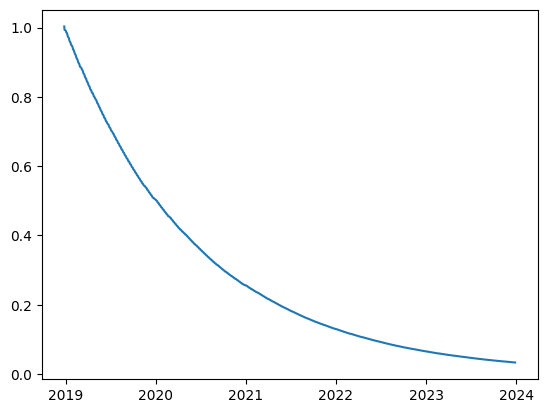

In [43]:
exemplo = get_first(dict_arima_pred_results["3 meses"])["pred_close"]
plt.plot(exemplo, label="previsto")
plt.show()

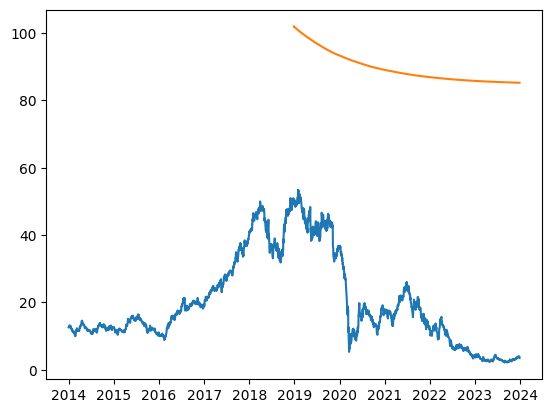

In [27]:
exemplo = get_first(dict_tickers_history)["Close"]
plt.plot(exemplo, label="original")
exemplo = get_first(dict_arima_pred_results["3 meses"])["pred_close_tratado"]
plt.plot(exemplo, label="previsto")
plt.show()

LSTM

In [29]:
from sklearn.preprocessing import StandardScaler

def preproc(data, lag, ratio):
    data=data.dropna().iloc[:, 0:1]
    Dates=data.index.unique()
    sc = StandardScaler()
    data.iloc[:, 0] = sc.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))
    for s in range(1, lag + 1):
        data['shift_{}'.format(s)] = data.iloc[:, 0].shift(s)
    X_data = data.dropna().drop(['Close'], axis=1)
    y_data = data.dropna()[['Close']]
    index=int(round(len(X_data)*ratio))
    X_data_train=X_data.iloc[:index,:]
    X_data_test =X_data.iloc[index+1:,:]
    y_data_train=y_data.iloc[:index,:]
    y_data_test =y_data.iloc[index+1:,:]
    return X_data_train,X_data_test,y_data_train,y_data_test,Dates;

a,b,c,d,e=preproc(data=get_first(dict_train_periods)["5 anos"], lag=max_look_back, ratio=0.70)

b.head()


,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
Date,,,,,,,
2017-07-07 00:00:00+00:00,0.464587,0.403120,0.372387,0.365558,0.340971,0.314336,0.324580
2017-07-10 00:00:00+00:00,0.452293,0.464587,0.403120,0.372387,0.365558,0.340971,0.314336
2017-07-11 00:00:00+00:00,0.438634,0.452293,0.464587,0.403120,0.372387,0.365558,0.340971
2017-07-12 00:00:00+00:00,0.441366,0.438634,0.452293,0.464587,0.403120,0.372387,0.365558
2017-07-13 00:00:00+00:00,0.464587,0.441366,0.438634,0.452293,0.464587,0.403120,0.372387


Trial 10 Complete [00h 00m 21s]
mse: 0.005825974823286136

Best mse So Far: 0.0022175132762640715
Total elapsed time: 00h 03m 38s
12/12 [==============================] - 1s 4ms/step


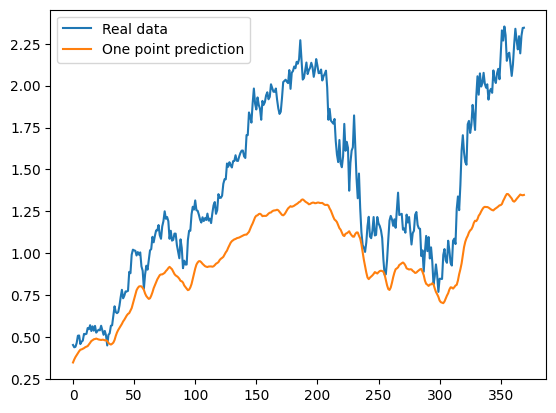

In [46]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


def preproc(data, lag, ratio):
    data=data.dropna().iloc[:, 0:1]
    Dates=data.index.unique()
    sc = StandardScaler()
    data.iloc[:, 0] = sc.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))
    for s in range(1, lag + 1):
        data['shift_{}'.format(s)] = data.iloc[:, 0].shift(s)
    X_data = data.dropna().drop(['Close'], axis=1)
    y_data = data.dropna()[['Close']]
    index=int(round(len(X_data)*ratio))
    X_data_train=X_data.iloc[:index,:]
    X_data_test =X_data.iloc[index+1:,:]
    y_data_train=y_data.iloc[:index,:]
    y_data_test =y_data.iloc[index+1:,:]
    return X_data_train,X_data_test,y_data_train,y_data_test,Dates;


def build_lstm_model(hp):
    model = Sequential()
    # Primeira camada LSTM, com ajuste no número de unidades
    model.add(LSTM(hp.Int('units', min_value=32, max_value=128, step=32), input_shape=(max_look_back, 1)))
    # Camada de Dropout para evitar overfitting
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)))
    # Camada densa de saída
    model.add(Dense(1))
    # Compilação do modelo
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model


#def predizer_precos_com_lstm(train, n_periods, max_look_back):
a,b,c,d,e=preproc(data=get_first(dict_train_periods)["5 anos"], lag=max_look_back, ratio=0.70)

#a.head()

a = a.values
b= b.values
c = c.values
d = d.values


tuner= kt.RandomSearch(
        build_lstm_model,
        objective='mse',
        max_trials=5,
        seed=42,
        executions_per_trial=3,
        overwrite=True # Não cria diretório para salvar os trials
        )

tuner.search(
        x=a,
        y=c,
        epochs=20,
        batch_size=128,
        validation_data=(b,d),
)

best_model = tuner.get_best_models(num_models=1)[0]

y_pred = best_model.predict(b)



plt.plot(d, label = "Real data")
plt.plot(y_pred, label = "One point prediction")
plt.legend()
plt.show()



In [20]:



def split_into_X_Y_lstm(history: DataFrame, time_step: int):
  X, Y = [], []
  close = DataFrame(history["Close"])
  for i in range(len(history) - time_step):
      a = close.iloc[i:(i + time_step)].values
      X.append(a)
      Y.append(close.iloc[i + time_step].values)  # O valor que queremos prever
  return np.array(X), np.array(Y)


def create_lstm(train, n_periods, look_back):
    limiar = int(len(train) * 0.5)
    X_train, y_train = split_into_X_Y_lstm(train.iloc[:limiar], look_back)
    X_test, y_test = split_into_X_Y_lstm(train.iloc[limiar:], look_back)
    
    # Cria o modelo
    # lstm_model = Sequential()
    # lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    # lstm_model.add(LSTM(50, return_sequences=False))
    # lstm_model.add(Dense(25))
    # lstm_model.add(Dense(1))
    # lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    lstm_model = Sequential()
    lstm_model.add(LSTM(4, input_shape=(look_back, 1)))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Treina o modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])
    return lstm_model
  
  
def predizer_valores_com_lstm(train, n_periods, look_back):
    time_step = int(len(train) * 0.3)
    lstm_model = create_lstm(train, time_step, look_back)    
    lst_pred = list()
    X_input = split_into_X_Y_lstm(train, time_step)[0][-1].tolist()
    for _ in range(len(n_periods)):
        pred = lstm_model.predict(np.array([X_input]), verbose=0)
        lst_pred.append(pred[0][0])
        
        # Atualiza X_input para a próxima previsão
        X_input.pop(0)
        X_input.append(pred[0])
    lst_pred = np.array(lst_pred)
    return pd.DataFrame({'pred_close': lst_pred}, index=test.index)


def predizer_valores_acoes(dict_train_history: dict, dict_test_history: dict, look_back) -> dict:
    dict_pred_results = None
    if (os.path.exists("dict_pred_results.pkl")):
        dict_pred_results = jl.load("dict_pred_results.pkl")
    else:
        dict_pred_results = dict()
    
    progress = 0
    for ticker_name, train_history in dict_train_history.items():
        test_history = dict_test_history[ticker_name]
        progress += 1
        print(f"Progresso: {progress} - {ticker_name}")
        if progress == 1: continue
        
        scaler=dict_diferenciacao_scaler[ticker_name][1]
        num_diffs=dict_diferenciacao_scaler[ticker_name][0]
        
        for periodo, train in separar_train_em_periodos(train_history).items():
            if not dict_pred_results.__contains__(periodo):
                dict_pred_results[periodo] = {"arima": dict(), "lstm": dict()}
            if not dict_pred_results[periodo]["arima"].__contains__(ticker_name):
                lst_pred = predizer_valores_com_arima(train, n_periods=len(test_history), look_back=look_back)
                lst_pred = inverse_normalization(lst_pred, scaler)
                lst_pred = inverse_differencing(train, lst_pred, num_diffs)
                dict_pred_results[periodo]["arima"][ticker_name] = pd.DataFrame({'pred_close': lst_pred}, index=train.index)
                jl.dump(dict_pred_results, "dict_pred_results.pkl")
            if not dict_pred_results[periodo]["lstm"].__contains__(ticker_name):
                lst_pred = predizer_valores_com_lstm(train, n_periods=len(test_history), look_back=look_back)
                lst_pred = inverse_normalization(lst_pred, scaler)
                lst_pred = inverse_differencing(train, lst_pred, num_diffs)
                dict_pred_results[periodo]["arima"][ticker_name] = pd.DataFrame({'pred_close': lst_pred}, index=train.index)
                jl.dump(dict_pred_results, "dict_pred_results.pkl")
        break
    return dict_pred_results

dict_pred_results = predizer_valores_acoes(dict_train_history, dict_test_history)

Progresso: 1 - CVCB3.SA
Progresso: 2 - EMBR3.SA



KeyboardInterrupt



Trial 10 Complete [00h 01m 31s]
mse: 0.17285553614298502

Best mse So Far: 0.013436534442007542
Total elapsed time: 00h 12m 21s
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


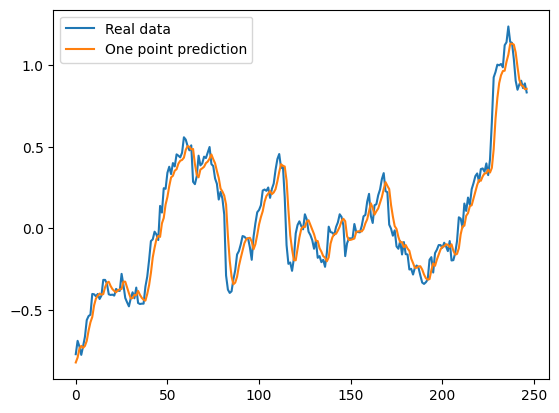

In [25]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

def preproc(data, lag, ratio):
    data=data.dropna().iloc[:, 0:1]
    Dates=data.index.unique()
    data.iloc[:, 0] = sc.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))
    for s in range(1, lag + 1):
        data['shift_{}'.format(s)] = data.iloc[:, 0].shift(s)
    X_data = data.dropna().drop(['Close'], axis=1)
    y_data = data.dropna()[['Close']]
    index=int(round(len(X_data)*ratio))
    X_data_train=X_data.iloc[:index,:]
    X_data_test =X_data.iloc[index+1:,:]
    y_data_train=y_data.iloc[:index,:]
    y_data_test =y_data.iloc[index+1:,:]
    return X_data_train,X_data_test,y_data_train,y_data_test,Dates;

data = dict_tickers_history["EMBR3.SA"]
a,b,c,d,e=preproc(data, lag=7, ratio=0.90)

a.head()

a = a.values
b= b.values
c = c.values
d = d.values
# print(a.shape)
# X_train_t = a.reshape(a.shape[0], 1, 24)
# X_test_t = b.reshape(b.shape[0], 1, 24)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

def build_model(hp, look_back):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=128,step=32),return_sequences=True, input_shape=(look_back,1)))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=32),return_sequences=True))
    model.add(LSTM(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

tuner= kt.RandomSearch(
        build_model,
        objective='mse',
        max_trials=10,
        executions_per_trial=3
        )

tuner.search(
        x=a,
        y=c,
        epochs=20,
        batch_size=128,
        validation_data=(b,d),
)

best_model = tuner.get_best_models(num_models=1)[0]

y_pred = best_model.predict(b)
plt.plot(d, label = "Real data")
plt.plot(y_pred, label = "One point prediction")
plt.legend()
plt.show()



In [ ]:

limiar = int(len(train) * 0.5)
X_train, y_train = split_into_X_Y_lstm(train.iloc[:limiar], max_look_back)
X_test, y_test = split_into_X_Y_lstm(train.iloc[limiar:], max_look_back)



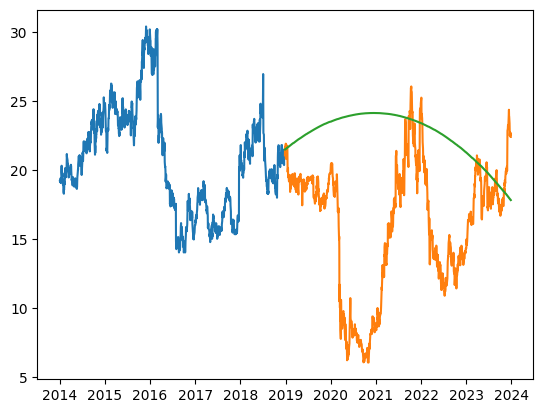

In [81]:
a = dict_train_history["EMBR3.SA"]
plt.plot(a.index, a["Close"].values)
b = dict_test_history["EMBR3.SA"]
plt.plot(b.index, b["Close"].values)
c = get_first(dict_pred_results['5 anos']["arima"])
plt.plot(c.index, c.values)
# d = get_first(dict_pred_results['1 mês']["lstm"])
# plt.plot(d.index, d.values)

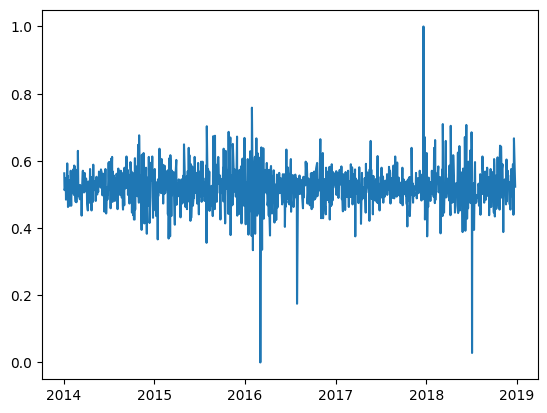

In [75]:
plt.plot(dict_train_history["EMBR3.SA"]['Normalized_Stationary_Close'].index, dict_train_history["EMBR3.SA"]['Normalized_Stationary_Close'].values)

### Analisando resultados

In [29]:
from sklearn.metrics import mean_absolute_percentage_error


def separar_test_em_periodos(history: dict) -> dict:
    h2 = {
        "1 mês": dict(),
        "3 meses": dict(),
        "6 meses": dict(),
        "1 ano": dict(),
        "3 anos": dict(),
        "5 anos": dict()
    }
    for ticker, h in history.items():
        min_date = h.index.min()
        h2["1 mês"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=1))
        h2["3 meses"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=3))
        h2["6 meses"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=6))
        h2["1 ano"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=1))
        h2["3 anos"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=3))
        h2["5 anos"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=5))
    return h2


def calculate_mapes(dict_pred_results, test_history):
    dict_mape = dict()
    for periodo, dict_modelo in dict_pred_results.items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            for ticker_name, y_pred in dict_ticker_name.items():
                if not dict_mape.__contains__(periodo):
                    dict_mape[periodo] = {"arima": dict(), "lstm": dict()}
                h = test_history[ticker_name]
                h = h.loc[h.index.isin(test_history[ticker_name].index)]
                dict_mape[periodo][modelo][ticker_name] = mean_absolute_percentage_error(y_true=get_prices(h), y_pred=y_pred[:len(h)]) * 100
    return dict_mape


def calculate_mape_means(dict_pred_results, test_history):
    dict_mape_means = dict()
    for periodo, dict_modelo in calculate_mapes(dict_pred_results, test_history).items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            sum = 0
            n = 0
            for _, mape in dict_ticker_name.items():
                sum += mape
                n+= 1
            if not dict_mape_means.__contains__(periodo):
                dict_mape_means[periodo] = dict()
            dict_mape_means[periodo][modelo] = float(sum / n) # media dos mapes
    return dict_mape_means


def mostrar_grafico_mapes(dict_pred_results, test_history):
    # Extrair os períodos, os valores do ARIMA e do LSTM
    for periodo, test in separar_test_em_periodos(test_history).items():
        dict_mape_means = calculate_mape_means(dict_pred_results, test)
        periodos = list(dict_mape_means.keys())
        arima_values = [dict_mape_means[periodo]['arima'] for periodo in periodos]
        lstm_values = [dict_mape_means[periodo]['lstm'] for periodo in periodos]
        
        # Configurações do gráfico
        bar_width = 0.35
        index = np.arange(len(periodos))
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Criar as barras
        ax.bar(index, arima_values, bar_width, label='ARIMA', color='b')
        ax.bar(index + bar_width, lstm_values, bar_width, label='LSTM', color='g')
        
        # Título e labels
        ax.set_xlabel('Períodos de treinamento')
        ax.set_ylabel('MAPE médio (%)')
        ax.set_title(f'Comparação entre ARIMA e LSTM por Período de treinamento prevendo {periodo}')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(periodos)
        ax.legend()
        
        # Exibir o gráfico
        plt.tight_layout()
        plt.show()
        
mostrar_grafico_mapes(dict_pred_results, dict_test_history)

KeyError: 'Normalized_Stationary_Close'